In [182]:
import pandas as pd
import os
import numpy as np
import math
from collections import Counter
import networkx as nx
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import community
from community import community_louvain


In [39]:

Data=pd.read_csv('./Experiment_Attendance.txt')

In [15]:
def get_Day(date):
    Days=['월','화','수','목','금','토','일']
    M=int(date[0:2])
    D=int(date[2:])
    if M==11: D+=31
    if M==12: D+=61
    return Days[(D-22)%7];

In [150]:
def get_elementwise_sim(routine1,routine2):
    sim=0
    for i in range(len(routine1)):
        sim+=pairwise_cosine(routine1[i],routine2[i])
        #for j in routine1[i].keys():
        #    sim+=routine2[i][j]*routine1[i][j]
    return sim/len(routine1)
def pairwise_cosine(r1,r2):
# argument : r1{1:0.1 , 2:0,3 , 3:0.6}, r2{1:0.5, 2:0.4, 4:0.1 ...}
# TODO: expand 
    m1= np.linalg.norm(list(r1.values()))
    m2= np.linalg.norm(list(r2.values()))
    dot_product = sum(r1[key]*r2.get(key, 0) for key in r1)
    if m1==0 or m2==0: return 0
    return dot_product/(m1*m2)

# 2. Sequence화 ( 144 Seq for One day)
User * Date * Seq[144] 

0:0~10, 1:10:01~11:00, ... 

Row Data : 2018-10-22 08:50:58,GWANJUNG1,SC00062,-85 => 530:58 => [53]

In [157]:
Day_Weight={'월':1,'화':1,'수':1,'목':1,'금':1,'토':2,'일':5}
Days=['월','화','수','목','금','토','일']
Categories=dict()
Categories={
    '33-331':1,'33-330':1,'33-328':1,'33-327':1,
    '33-231':1,'33-230':1,'33-229':1,'33-228':1,'33-226':1,'33-225':1,
    '33-B1L':3,
    '43-1':4,
    'BONGUS':5,
    'MugOut':6,'Muginside':6,
    'Gym':7,
    'HH1':8,'HH2':8,'HH3':8,
    'GWANJUNG1':9,'Gwanjung2':9,'GWANJUNG3':9,'Gwanjung3':9,'GWANJUNG1':9,
    'CU':10,
    'BBQ':11,
    'Sinyang3':12,
    'Doodam3':13,
    'Doodam4':14,
    'Doodam':15,
    'Haedong':16
}

In [68]:
timegaps=600 # 10 Minutes 
user_daily_routine=[]
for i in range(100):
    user_daily_routine.append([])
    for j in range(50):
        user_daily_routine[-1].append([])
        for k in range(int(86400/timegaps)+1):
            user_daily_routine[-1][-1].append(0)

all_files=os.listdir("./Raw/")
txt_files=[];
for X in all_files:
    if X[-4:]=='.txt':
        txt_files.append(X);
print(len(txt_files))  # only text files

48


In [76]:
def extract_routine(source,S,Interval):
    length=int(86400/Interval)
    routine=[]
    for i in range(length+1):
        routine.append(Counter())
    for X in open(source,'r').readlines():
        if S not in X : continue
        place=X.split(',')[1]
        hour,minute,second=map(int,X.split(',')[0].split(' ')[1].split(':'))
        try:
            routine[math.ceil((hour*3600+minute*60+second)/Interval)][Categories[place]]+=1
        except:
            print(X)
    # routine : Counter의 집합, 각 Counter : [Category, 신호수]
    # TODO : [1:80% 2,20%] VS [1:20%, 3:60%, 2:20%] -> 0.2+0.2 = 0.4 or 
    # 맥스로 하면 좋은점: 쉬움
    # 확률곱으로 하면 좋은점 : 좀더 자세함/ 한친구가 늦게오면? 확률곱이 더 좋은데 
    # 확률곱으로 하자! (행동패턴이 복잡한것도 캐치가능 Ex 수업->봉구스->수업)
    normalized_routine=[]
    for t in routine:
        total=sum(t.values())
        for x in t.keys():
            t[x]=t[x]/total
        normalized_routine.append(t)
    return normalized_routine
    

> Read 하고 10분간의 데이터 모아서 가장 높은 애로 선택(Counter) 하기

> Seq Index로 Iter, Counter 만들어서 카테고리 값 추가

In [79]:
Days=[]
txt_files.sort()
for Target in range(10,99):
    S='SC000'+str(Target)
    for i in range(len(txt_files)):
        if Target==10: Days.append(get_Day(txt_files[i][0:4]))
#        print(txt_files[i],get_Day(txt_files[i][0:4]))
        user_daily_routine[Target][i]=extract_routine('./Raw/'+txt_files[i],S,timegaps)


In [166]:
T=15
Max=0
G=nx.Graph()
for i in range(10,99):
    for j in range(i+1,99):
        sim=0
        for day in range(0,47):
            sim+=get_elementwise_sim(user_daily_routine[i][day],user_daily_routine[j][day])*Day_Weight[Days[day%7]]
            #if sim>0.2: 
                #print("day %d : %d between %d : %lf" %(day, i,j,sim))
            if sim>Max: Max=sim
        G.add_weighted_edges_from([(i,j,sim)])
print(Max)

3.874003574691735


SUM= 83


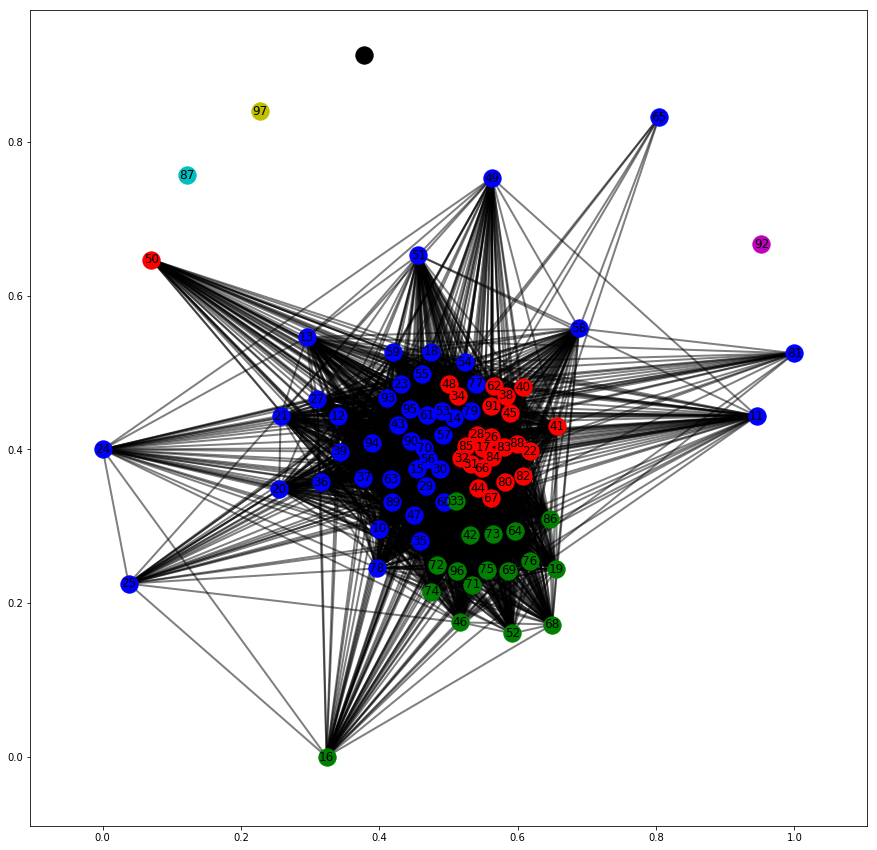

In [189]:
figure(figsize=(15,15))

partition = community_louvain.best_partition(G)
print("SUM=",sum(partition.values()))
#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0
CMAP=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'];
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    try:
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 300,
                                node_color = CMAP[int(count-1)])
    except:
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 300,
                                node_color = (0.9,0.9,0.9))            



#pos = nx.spring_layout(G)
color_map = []
nlarge=[u for u in G.nodes() if G.degree(u) >80]
nsmall=[u for u in G.nodes() if G.degree(u)<=80]
nsingle=[u for u in G.nodes() if G.degree(u) ==0]
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] >0.0]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] and d['weight']<=0.0]

nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif',font_color='black')
nx.draw_networkx_edges(G,pos,edgelist=elarge,width=2,alpha=0.5,edge_color='black')
plt.show()    

In [132]:
user_daily_routine[14][2][80]

Counter({16: 1.0})

In [143]:
list(user_daily_routine[70][2][90].values())

[1.0]

In [145]:
pairwise_cosine(user_daily_routine[14][2][80],user_daily_routine[70][2][90])

0.0

In [149]:
sim

nan